In [1]:
from preprocessing import preprocess_flowdata, preprocess_graph
from dataset import WaterFlowDataSet
from model import Model
import torch
import hyperparameters as hp
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

In [2]:
df_node_features, df_node_features_strata = preprocess_flowdata(hp.FLOWDATA_PATH)
edge_indices, edge_weights = preprocess_graph(hp.SUBSETGRAPH_PATH)

Rows per month: year_month
2020-01    2976
2020-02    2699
2020-03    2976
2020-04    2756
2020-05    1581
2020-06    2067
2020-07    2147
2020-08    2098
2020-09    1522
2020-10     200
2020-11     985
2020-12    1157
2021-01    2361
2021-02    2688
2021-03    2976
2021-04    2880
2021-05     457
2022-02     584
2022-03    2029
2023-05    2195
2023-06    2817
2023-07    2221
2023-08    2884
2023-09    2796
2023-10    2757
2023-11    2354
2023-12    2549
2024-01    1969
2024-02    2519
2024-03    2698
2024-04    1885
2024-05    2804
2024-06    2317
2024-07    2495
2024-08    1220
2024-09     459
Freq: M, Name: count, dtype: int64

Gap summary for train set:
Gap before 2020-04-29 23:00:00: 0 days 08:15:00 (from 2020-04-29 14:45:00 to 2020-04-29 23:00:00)
Gap before 2020-04-30 23:00:00: 0 days 23:15:00 (from 2020-04-29 23:45:00 to 2020-04-30 23:00:00)
Gap before 2020-05-01 23:00:00: 0 days 23:15:00 (from 2020-04-30 23:45:00 to 2020-05-01 23:00:00)
Gap before 2020-05-02 23:00:00: 0 days 2

In [3]:
train_dataset = WaterFlowDataSet(df_node_features[0], df_node_features_strata[0], edge_indices, edge_weights, hp.FORECAST_WINDOW)
val_dataset = WaterFlowDataSet(df_node_features[1], df_node_features_strata[1], edge_indices, edge_weights, hp.FORECAST_WINDOW)
test_dataset = WaterFlowDataSet(df_node_features[2], df_node_features_strata[2], edge_indices, edge_weights, hp.FORECAST_WINDOW)

In [4]:
WIN_SIZE = hp.TOTAL_WINDOW

model = Model(
    input_channels = WIN_SIZE, 
    hidden_channels = WIN_SIZE, 
    output_channels = WIN_SIZE, 
    num_heads = 4, 
    embed_dim = 32,
    context_window = hp.CONTEXT_WINDOW,
    forecast_window = hp.FORECAST_WINDOW,
    context_dim = WIN_SIZE
)

optimiser = torch.optim.AdamW(model.parameters(), lr=hp.LEARNING_RATE)
train_criterion = torch.nn.MSELoss()

In [5]:
def train(model, optimiser, loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimiser.zero_grad()
        out = model(batch.x, batch.edge_index, batch.context) 
        loss = train_criterion(out[batch.mask], batch.y[batch.mask].squeeze())
        loss.backward()
        optimiser.step()
        total_loss += loss.item() * batch.num_graphs 

    return total_loss / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.context) 
            loss = train_criterion(out[batch.mask], batch.y[batch.mask].squeeze())
            total_loss += loss.item() * batch.num_graphs 
    
    return total_loss / len(loader.dataset)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=hp.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hp.BATCH_SIZE, shuffle=True)

train_loss = []
val_loss = []

for epoch in range(hp.NB_EPOCHS):
    epoch_train_loss = train(model, optimiser, train_loader)
    epoch_val_loss = validate(model, val_loader)
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")

Epoch 1, Train Loss: 1.1532668950995044, Val Loss: 0.7681661248207092
Epoch 2, Train Loss: 0.6850805913908242, Val Loss: 0.7173104882240295
Epoch 3, Train Loss: 0.688446195873283, Val Loss: 0.7367915166051764
Epoch 4, Train Loss: 0.6979212672752741, Val Loss: 0.8237606349744295
Epoch 5, Train Loss: 0.6668356738146946, Val Loss: 0.5271380794675726
Epoch 6, Train Loss: 0.6092079452861695, Val Loss: 0.6358189331857782
Epoch 7, Train Loss: 0.563584039902546, Val Loss: 0.6206112723601492
Epoch 8, Train Loss: 0.5541164751588945, Val Loss: 0.5201059391624049
Epoch 9, Train Loss: 0.5862932113500742, Val Loss: 0.5993641050238359
Epoch 10, Train Loss: 0.5409675519141925, Val Loss: 0.45277012963044017
Epoch 11, Train Loss: 0.5239663765980647, Val Loss: 0.36486920871232686
Epoch 12, Train Loss: 0.47891241717620714, Val Loss: 0.38239043009908574
Epoch 13, Train Loss: 0.5111063992130686, Val Loss: 0.5038403711820904
Epoch 14, Train Loss: 0.4395474631052751, Val Loss: 0.28028120806342677
Epoch 15, Tr

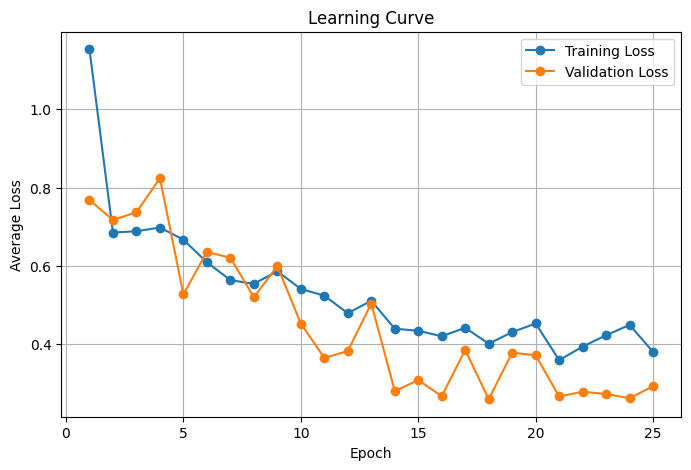

In [7]:
plt.figure(figsize=(8,5))

plt.plot(range(1, hp.NB_EPOCHS + 1), train_loss, marker='o', label='Training Loss')
plt.plot(range(1, hp.NB_EPOCHS + 1), val_loss, marker='o', label='Validation Loss')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

plt.grid(True)
plt.legend()
plt.show()

In [8]:
test_criterion = torch.nn.MSELoss()

def calc_index_of_agreement(y_pred, y_actual, eps=1e-8):
    y_actual_mean = torch.mean(y_actual)

    numerator = torch.sum((y_pred - y_actual) ** 2)
    denominator = torch.sum((torch.abs(y_pred - y_actual_mean) + torch.abs(y_actual - y_actual_mean)) ** 2)
    
    index_of_agreement = 1 - numerator / (denominator + eps)
    return index_of_agreement



def test(model, loader):
    model.eval()
    total_loss = 0.0

    all_y_pred = []
    all_y_actual = []

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.context)
            mask = ~batch.mask 
            y_actual = batch.y[mask]

            if mask.sum() == 0:
                continue

            y_pred = out[mask]

            loss = test_criterion(y_pred, y_actual)
            total_loss += loss.item() * batch.num_graphs

            all_y_pred.append(y_pred)
            all_y_actual.append(y_actual)

    average_loss = total_loss / len(loader.dataset)

    all_y_pred = torch.cat(all_y_pred, dim=0)
    all_y_actual = torch.cat(all_y_actual, dim=0)

    index_of_agreement = calc_index_of_agreement(all_y_pred, all_y_actual)

    return average_loss, index_of_agreement

In [9]:
test_loader = DataLoader(test_dataset, batch_size=hp.BATCH_SIZE, shuffle=True)

average_loss, index_of_agreement = test(model, test_loader)

print(f"Test Loss: {average_loss}")
print(f"Index of Agreement: {index_of_agreement}")

Test Loss: 0.3534270028273265
Index of Agreement: 0.8443342447280884
